In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
import umap
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats
from statsmodels.tsa import stattools
warnings.filterwarnings("ignore")
plt.rcParams["font.size"] = 10

In [2]:
def style_figs(title,xlabel,ylabel,ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlabel,fontsize=12,loc='right')
    ax.set_ylabel(ylabel,fontsize=12,loc='bottom')
    ax.set_title(title,fontsize=14,loc='left',y=1.05)
    

## Look for consistency across datasets


In [3]:
########## Load each data frame into dictionary - Permian ##########
file_names = ! ls /home/savannah/quantico/Permian/
dict_dfs = {}
for file_name in file_names:
    #remove gamma lag by 50ft
    df=pd.read_csv(f'/home/savannah/quantico/Permian/{file_name}')
    remove_max=df[df['DEPTH(ft)']<=50].index.max()
    array =np.empty((remove_max+1))
    array[:] = np.nan
    new_gamma = list(array) + list(df['Gamma(gapi)']) 
    new_gamma= new_gamma[:-remove_max-1]
    df['Gamma(gapi)'] = new_gamma
    dict_dfs[file_name]=df
    
########## Document consistent column names across all 9 dataframes - and exceptions ##########
cols=[]
for k,v in dict_dfs.items():
    cols.append(list(v.columns))
col_names=pd.DataFrame(cols).T
col_names.columns=file_names

# set(col_names[file_names[0]].dropna()).intersection(set(col_names[file_names[1]]))
all_col_names=[]
for file_name in file_names:
    cols = list(col_names[file_name].dropna())
    all_col_names.extend(cols)
unique_col_names = list(pd.Series(all_col_names).drop_duplicates())

print(f'There are {len(file_names)} datasets\nwith a total of {len(unique_col_names)} unique columns\n')
consistent_col_names = list(pd.Series(all_col_names).value_counts()[pd.Series(all_col_names).value_counts()==len(file_names)].index)
print(f'There are {len(consistent_col_names)} columns that are consistent across all datasets:\n{consistent_col_names}\n')
inconsistent_cols= list(pd.Series(all_col_names).value_counts()[pd.Series(all_col_names).value_counts()!=len(file_names)].index)
print(f'There are {len(inconsistent_cols)} columns that are inconsistent across all datasets:\n{inconsistent_cols}\n')
# which inconsistent columns are in which data set - 
inconsistent_data={}
for file_name in file_names:
    inconsistent_data_cols = list(col_names[file_name][col_names[file_name].isin(inconsistent_cols)])
    if inconsistent_data_cols!=[]:
        inconsistent_data[file_name] = inconsistent_data_cols
print(f'Inconsistent data columns can be found in these datasets:\n{inconsistent_data}')

There are 9 datasets
with a total of 21 unique columns

There are 15 columns that are consistent across all datasets:
['DEPTH(ft)', 'ROP(ft / min)', 'MSE1(ksi)', 'WOB(klbs)', 'TVD(ft)', 'TPO(gal / min)', 'AZM(deg)', 'RPM(rpm)', 'SPP(psi)', 'NS(ft)', 'INC(deg)', 'Gamma(gapi)', 'EW(ft)', 'DIFP(psi)', 'BIT(in)']

There are 6 columns that are inconsistent across all datasets:
['TOR(ft_lb)', 'MSE2(ksi)', 'MSE(ksi)', 'DLG(deg/100ft)', 'LAGTIME(min)', 'SLIDE(units)']

Inconsistent data columns can be found in these datasets:
{'OXY_AK235H_MDS.csv': ['TOR(ft_lb)', 'MSE2(ksi)', 'MSE(ksi)'], 'OXY_Gorilla204H_MDS.csv': ['DLG(deg/100ft)', 'LAGTIME(min)', 'SLIDE(units)', 'TOR(ft_lb)', 'MSE2(ksi)', 'MSE(ksi)']}


In [4]:
# these are the cols of interest
consistent_col_names =['DEPTH(ft)',
 'ROP(ft / min)',
 'WOB(klbs)',
 'TPO(gal / min)',
 'RPM(rpm)',
 'SPP(psi)',
 'INC(deg)',
 'Gamma(gapi)',
 'DIFP(psi)',
 'BIT(in)']

2.9081955767015558e-09

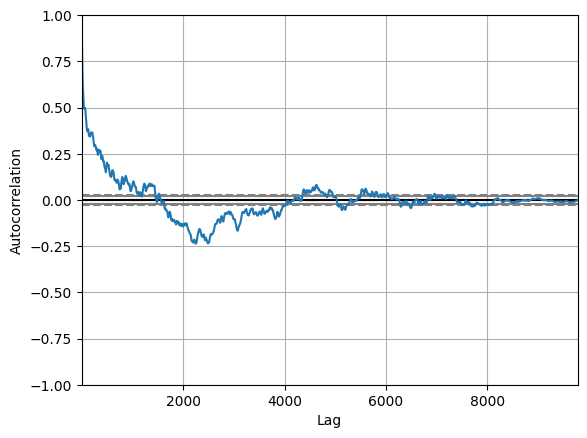

In [15]:
pd.plotting.autocorrelation_plot(dict_dfs[file_name]['Gamma(gapi)'].dropna())
stattools.adfuller(dict_dfs[file_name]['Gamma(gapi)'].dropna())[1] # <.05 is stationary

2.0513647190426474e-09

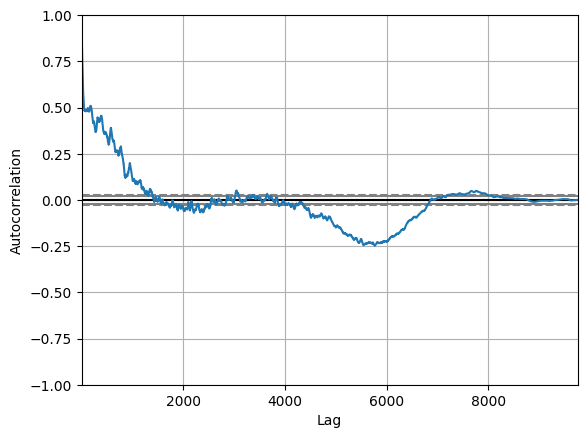

In [14]:
pd.plotting.autocorrelation_plot(dict_dfs[file_name]['ROP(ft / min)'].dropna())
stattools.adfuller(dict_dfs[file_name]['ROP(ft / min)'].dropna())[1] # <.05 is stationary

In [5]:
# we assume that missing data is at beginning and ends of time series only - testing this assumption
cs={}
for k,df in dict_dfs.items():
    for c in df.columns:
        diffs=(np.diff(df[c].dropna().index)!=1).sum()
        if diffs !=0:
            cs[f'{k}_{c}']=diffs
print(f'These datasets and cols have missing data in the middle of available time series:\n{cs}\nThis violates our assumption')

These datasets and cols have missing data in the middle of available time series:
{'OXY_AK235H_MDS.csv_BIT(in)': 1, 'OXY_AK235H_MDS.csv_MSE1(ksi)': 1, 'OXY_AK235H_MDS.csv_MSE2(ksi)': 1, 'OXY_AK235H_MDS.csv_MSE(ksi)': 1}
This violates our assumption


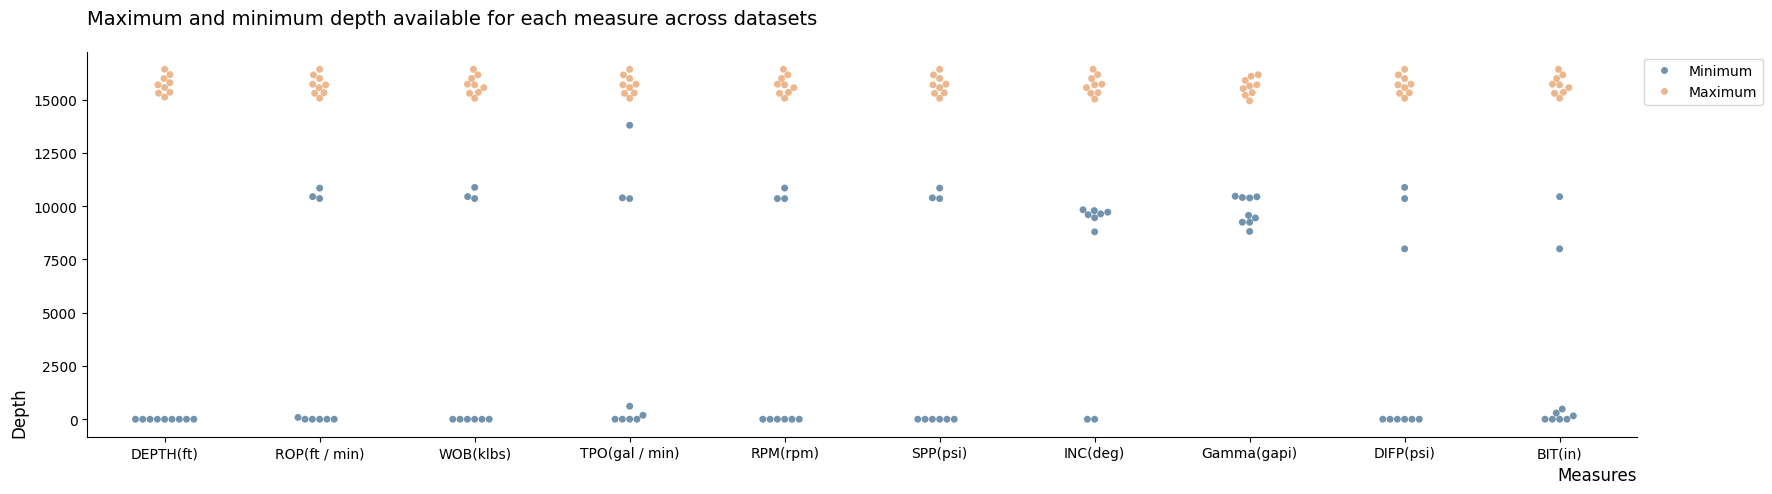

In [6]:
########### Maximum and minimum depth available for each measure across datasets ###########
min_depth = {}
max_depth = {}
for col in consistent_col_names:
    min_d=[]
    max_d=[]
    for k,df in dict_dfs.items():
        if col!='DEPTH(ft)':
            avail_data = df[['DEPTH(ft)',col]].dropna()
            min_d.append(avail_data['DEPTH(ft)'].min())
            max_d.append(avail_data['DEPTH(ft)'].max())
        else:
            avail_data = df['DEPTH(ft)'].dropna()
            min_d.append(avail_data.min())
            max_d.append(avail_data.max())
        
    min_depth[col]=min_d
    max_depth[col]=max_d
min_depth = pd.DataFrame(min_depth)
max_depth = pd.DataFrame(max_depth)
min_depth = min_depth.stack().reset_index()
min_depth.columns=['a','measure','Depth']
min_depth =min_depth[['measure','Depth']]
max_depth = max_depth.stack().reset_index()
max_depth.columns=['a','measure','Depth']
max_depth =max_depth[['measure','Depth']]
max_depth['stat']='Maximum'
min_depth['stat']='Minimum'
depthstats_across_datasets = pd.concat([min_depth,max_depth])

fig, ax =plt.subplots(figsize=(20,5))
sns.swarmplot(data=depthstats_across_datasets,y='Depth', x='measure',alpha=.6,hue='stat',dodge=False,palette=['#154c79','#e28743'])
ax.legend(bbox_to_anchor=(1,1))
title='Maximum and minimum depth available for each measure across datasets'
xlabel='Measures'
ylabel='Depth'
style_figs(title,xlabel,ylabel,ax)

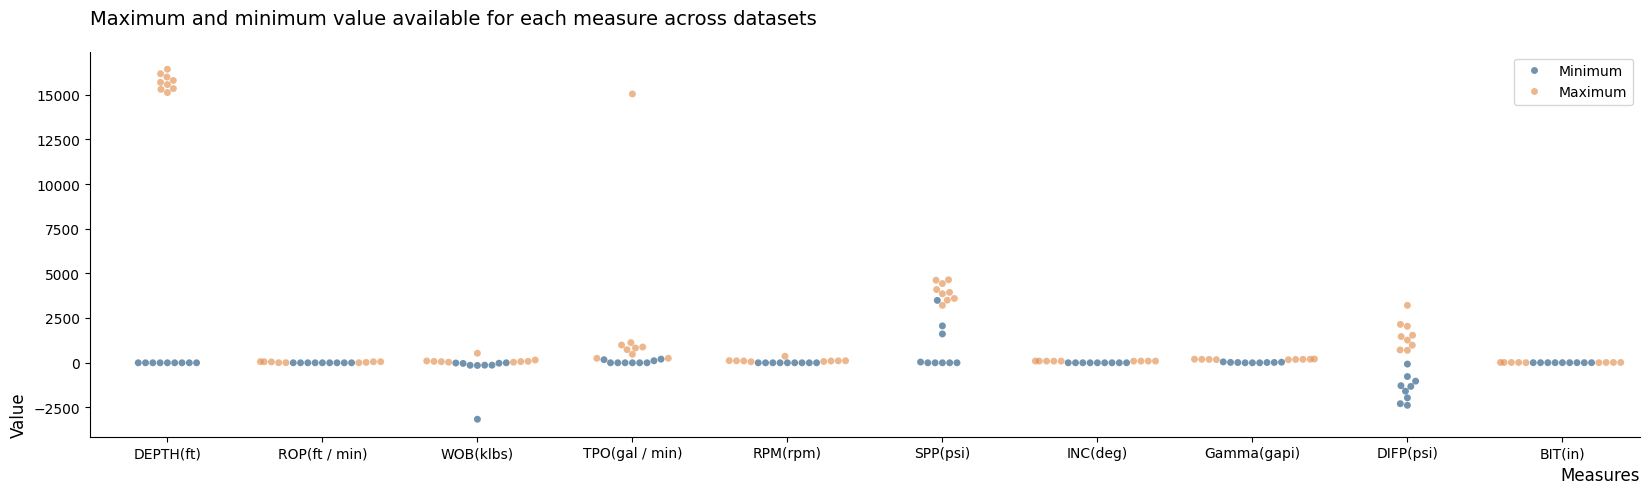

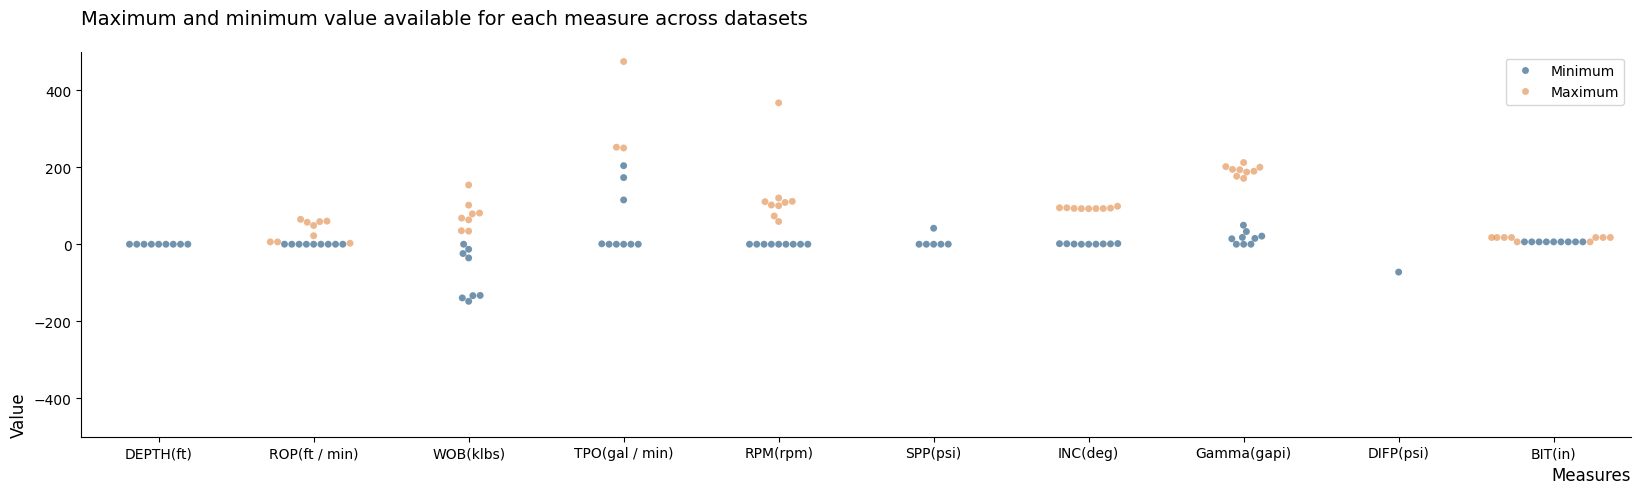

In [7]:
########### Maximum and minimum value available for each measure across datasets ###########
min_value = {}
max_value = {}
for col in consistent_col_names:
    min_d=[]
    max_d=[]
    for k,df in dict_dfs.items():
        avail_data = df[col].dropna()
        min_d.append(avail_data.min())
        max_d.append(avail_data.max())
    min_value[col]=min_d
    max_value[col]=max_d
min_value = pd.DataFrame(min_value)
max_value = pd.DataFrame(max_value)
min_value = min_value.stack().reset_index()
min_value.columns=['a','measure','Value']
min_value =min_value[['measure','Value']]
max_value = max_value.stack().reset_index()
max_value.columns=['a','measure','Value']
max_value =max_value[['measure','Value']]
max_value['stat']='Maximum'
min_value['stat']='Minimum'
depthstats_across_datasets = pd.concat([min_value,max_value])

fig, ax =plt.subplots(figsize=(20,5))
sns.swarmplot(data=depthstats_across_datasets,y='Value', x='measure',alpha=.6,hue='stat',dodge=False,palette=['#154c79','#e28743'])
ax.legend(bbox_to_anchor=(1,1))
title='Maximum and minimum value available for each measure across datasets'
xlabel='Measures'
ylabel='Value'
style_figs(title,xlabel,ylabel,ax)

fig, ax =plt.subplots(figsize=(20,5))
sns.swarmplot(data=depthstats_across_datasets,y='Value', x='measure',alpha=.6,hue='stat',dodge=False,palette=['#154c79','#e28743'])
ax.legend(bbox_to_anchor=(1,1))
title='Maximum and minimum value available for each measure across datasets'
xlabel='Measures'
ylabel='Value'
ax.set_ylim(-500,500)
style_figs(title,xlabel,ylabel,ax)

# add descriptive stats? mean/std etc? and across datasets

In [8]:
for k,df in dict_dfs.items():
    df=df[consistent_col_names]
    print(df.describe())

          DEPTH(ft)  ROP(ft / min)     WOB(klbs)  TPO(gal / min)  \
count  30256.000000   30138.000000  30140.000000    28918.000000   
mean    7563.750000       1.565460     16.523147      392.567588   
std     4367.149604       5.011157     12.950395      158.769589   
min        0.000000       0.000000   -148.300000        0.000000   
25%     3781.875000       0.581667     10.300000      245.000000   
50%     7563.750000       0.876667     15.522500      481.000000   
75%    11345.625000       1.168333     22.000000      496.000000   
max    15127.500000      59.945000     78.800000     1129.000000   

           RPM(rpm)      SPP(psi)      INC(deg)  Gamma(gapi)     DIFP(psi)  \
count  30140.000000  30140.000000  12466.000000  8955.000000  30140.000000   
mean      51.841936   2082.206258     69.168977   111.456354    253.710800   
std       28.391378    778.677949     35.632259    27.441886    155.516453   
min        0.000000      0.000000      0.900000    49.387100  -1282.700000 

In [9]:
def get_diff(df):
    nan_mask = np.isnan(df)
    df[nan_mask] = 0
    diff = df.diff()
    diff[nan_mask] = np.nan
    diff['DEPTH(ft)']=df['DEPTH(ft)']
    return diff
diff=0

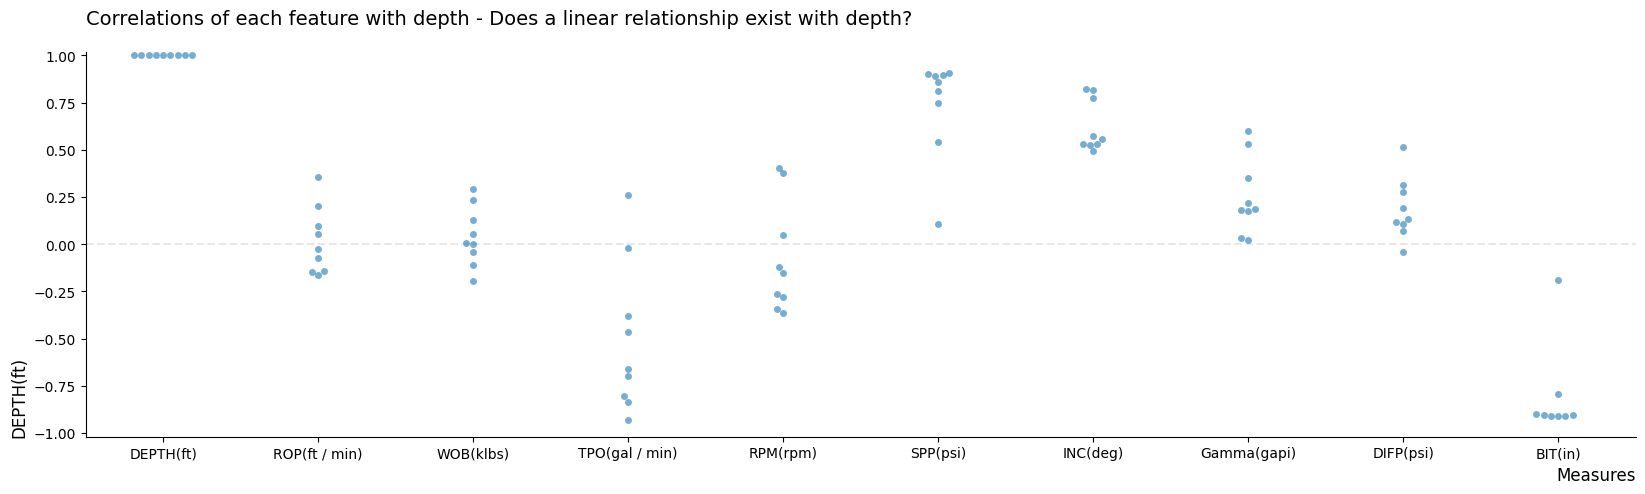

In [9]:
######## Correlations of each feature with depth - Does a linear relationship exist with depth? ###########
corr_dfs=pd.DataFrame()
for k,df in dict_dfs.items():
    df=df[consistent_col_names]
    if diff==1:
        df=get_diff(df)
    corr_df=df.corr()
    corr_df=corr_df['DEPTH(ft)'].reset_index()
    corr_df.columns=['Measures','DEPTH(ft)']
    corr_df['dataset']=k
    corr_dfs = pd.concat([corr_dfs,corr_df])
corr_dfs=corr_dfs.reset_index(drop=True)

fig, ax =plt.subplots(figsize=(20,5))
sns.swarmplot(data=corr_dfs,y='DEPTH(ft)',x='Measures',alpha=.6)
title='Correlations of each feature with depth - Does a linear relationship exist with depth?'
xlabel='Measures'
ylabel='DEPTH(ft)'
ax.set_ylim(-1.02,1.02)
ax.axhline(0,zorder=0,linestyle='--',alpha=.5,color='lightgrey')
style_figs(title,xlabel,ylabel,ax)

## Question do corrs differ based on min depth?? 

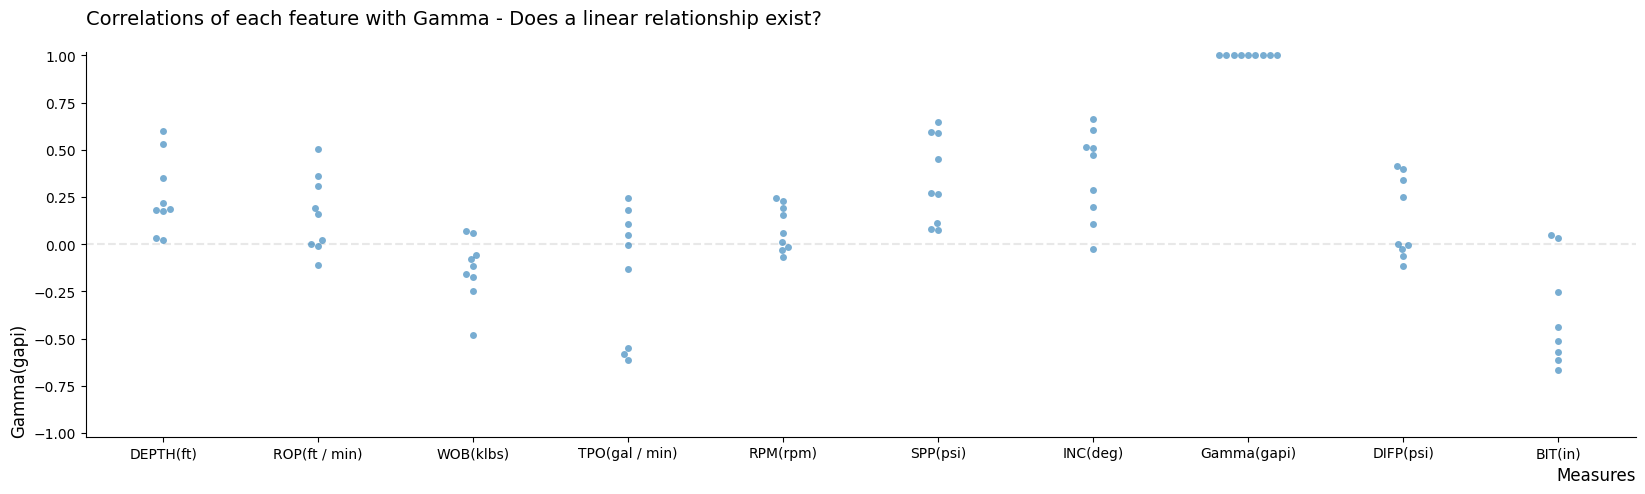

In [10]:
######## Correlations of each feature with Gamma ###########
corr_dfs=pd.DataFrame()
for k,df in dict_dfs.items():
    df=df[consistent_col_names]
    if diff==1:
        df=get_diff(df)
    corr_df=df.corr()
    corr_df=corr_df['Gamma(gapi)'].reset_index()
    corr_df.columns=['Measures','Gamma(gapi)']
    corr_df['dataset']=k
    corr_dfs = pd.concat([corr_dfs,corr_df])
corr_dfs=corr_dfs.reset_index(drop=True)

fig, ax =plt.subplots(figsize=(20,5))
sns.swarmplot(data=corr_dfs,y='Gamma(gapi)',x='Measures',alpha=.6)
title='Correlations of each feature with Gamma - Does a linear relationship exist?'
xlabel='Measures'
ylabel='Gamma(gapi)'
ax.set_ylim(-1.02,1.02)
ax.axhline(0,zorder=0,linestyle='--',alpha=.5,color='lightgrey')
style_figs(title,xlabel,ylabel,ax)

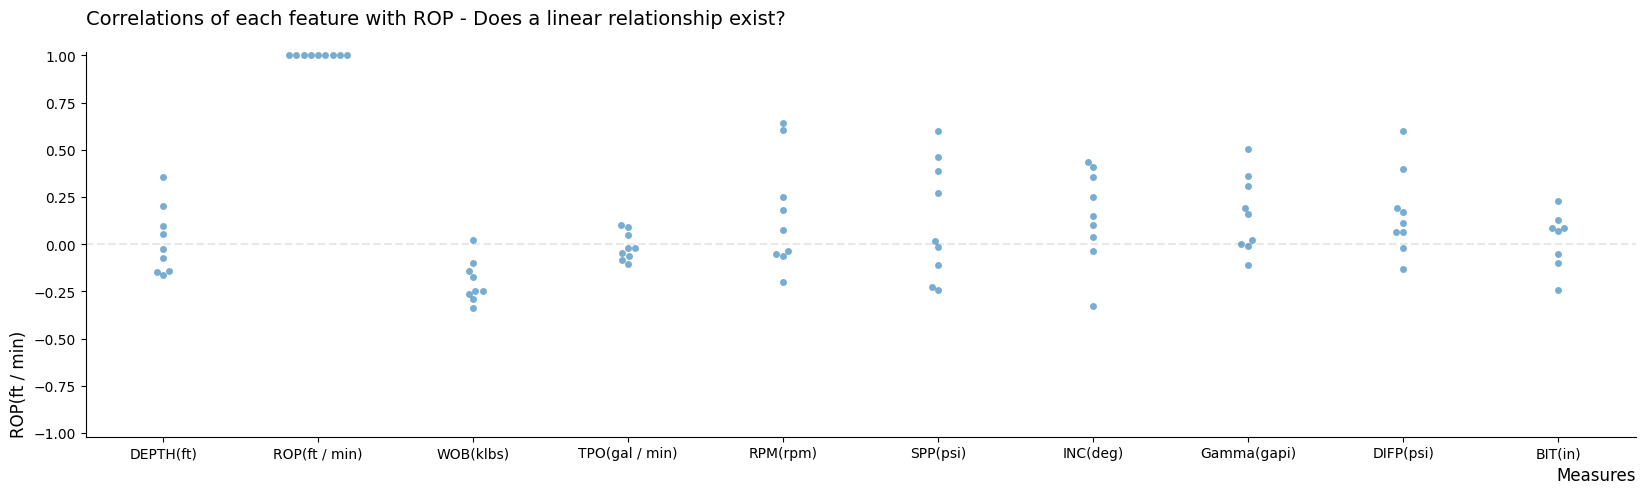

In [11]:
######## Correlations of each feature with ROP ###########
corr_dfs=pd.DataFrame()
for k,df in dict_dfs.items():
    df=df[consistent_col_names]
    if diff==1:
        df=get_diff(df)
    corr_df=df.corr()
    corr_df=corr_df['ROP(ft / min)'].reset_index()
    corr_df.columns=['Measures','ROP(ft / min)']
    corr_df['dataset']=k
    corr_dfs = pd.concat([corr_dfs,corr_df])
corr_dfs=corr_dfs.reset_index(drop=True)

fig, ax =plt.subplots(figsize=(20,5))
sns.swarmplot(data=corr_dfs,y='ROP(ft / min)',x='Measures',alpha=.6)
title='Correlations of each feature with ROP - Does a linear relationship exist?'
xlabel='Measures'
ylabel='ROP(ft / min)'
ax.set_ylim(-1.02,1.02)
ax.axhline(0,zorder=0,linestyle='--',alpha=.5,color='lightgrey')
style_figs(title,xlabel,ylabel,ax)

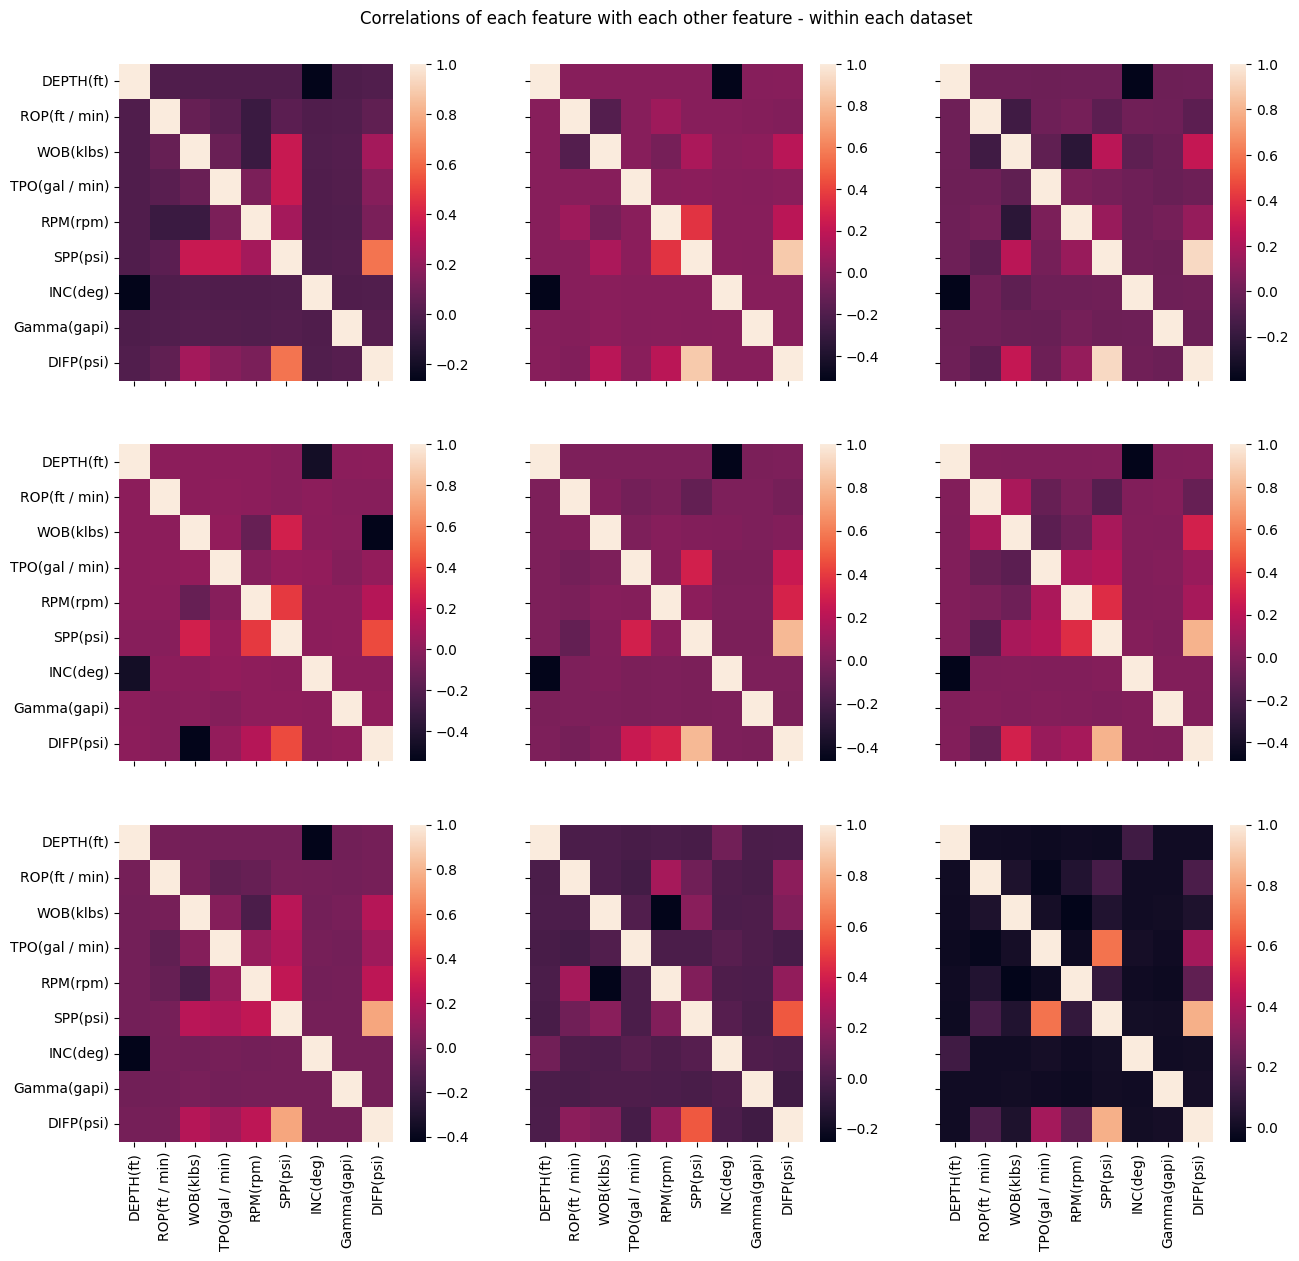

In [245]:
############ Correlations of each feature with each other feature - within each dataset ############
i=0
j=0

fig, ax =plt.subplots(3,3,figsize=(15,14))
for k,df in dict_dfs.items():
    df=df[consistent_col_names[:-1]]
    if diff==1:
        df=get_diff(df)
    corr_df=df.corr()
    sns.heatmap(data=corr_df,ax=ax[i,j])
    if (i==0) & (j==1):
        ax[i,j].set_title('Correlations of each feature with each other feature - within each dataset',y=1.1)
    if i<2:
        ax[i,j].set_xticklabels('')
    if j>0:
        ax[i,j].set_yticklabels('')
    j=j+1
    if j>=3:
        i=i+1
    if j>=3:
        j=0


    

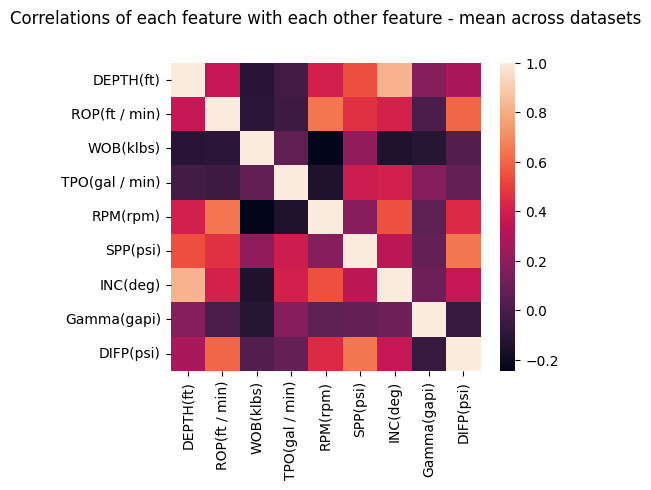

In [13]:
corr_dfs=[]
for k,df in dict_dfs.items():
    df=df[consistent_col_names]
    if diff==1:
        df=get_diff(df)
    corr_dfs.append(corr_df)
corr_dfs=pd.concat(corr_dfs)
corr_dfs=corr_dfs.T

mean_corr_df=pd.DataFrame()
for consistent_col_name in consistent_col_names:
    mean_corr_df = pd.concat([mean_corr_df,pd.DataFrame(corr_dfs[consistent_col_name].mean(axis=1),columns=[consistent_col_name])],axis=1)
mean_corr_df = mean_corr_df.dropna(how='all').dropna(axis=1)
fig, ax =plt.subplots(figsize=(5,4))
sns.heatmap(data=mean_corr_df,ax=ax)
ax.set_title('Correlations of each feature with each other feature - mean across datasets',y=1.1);


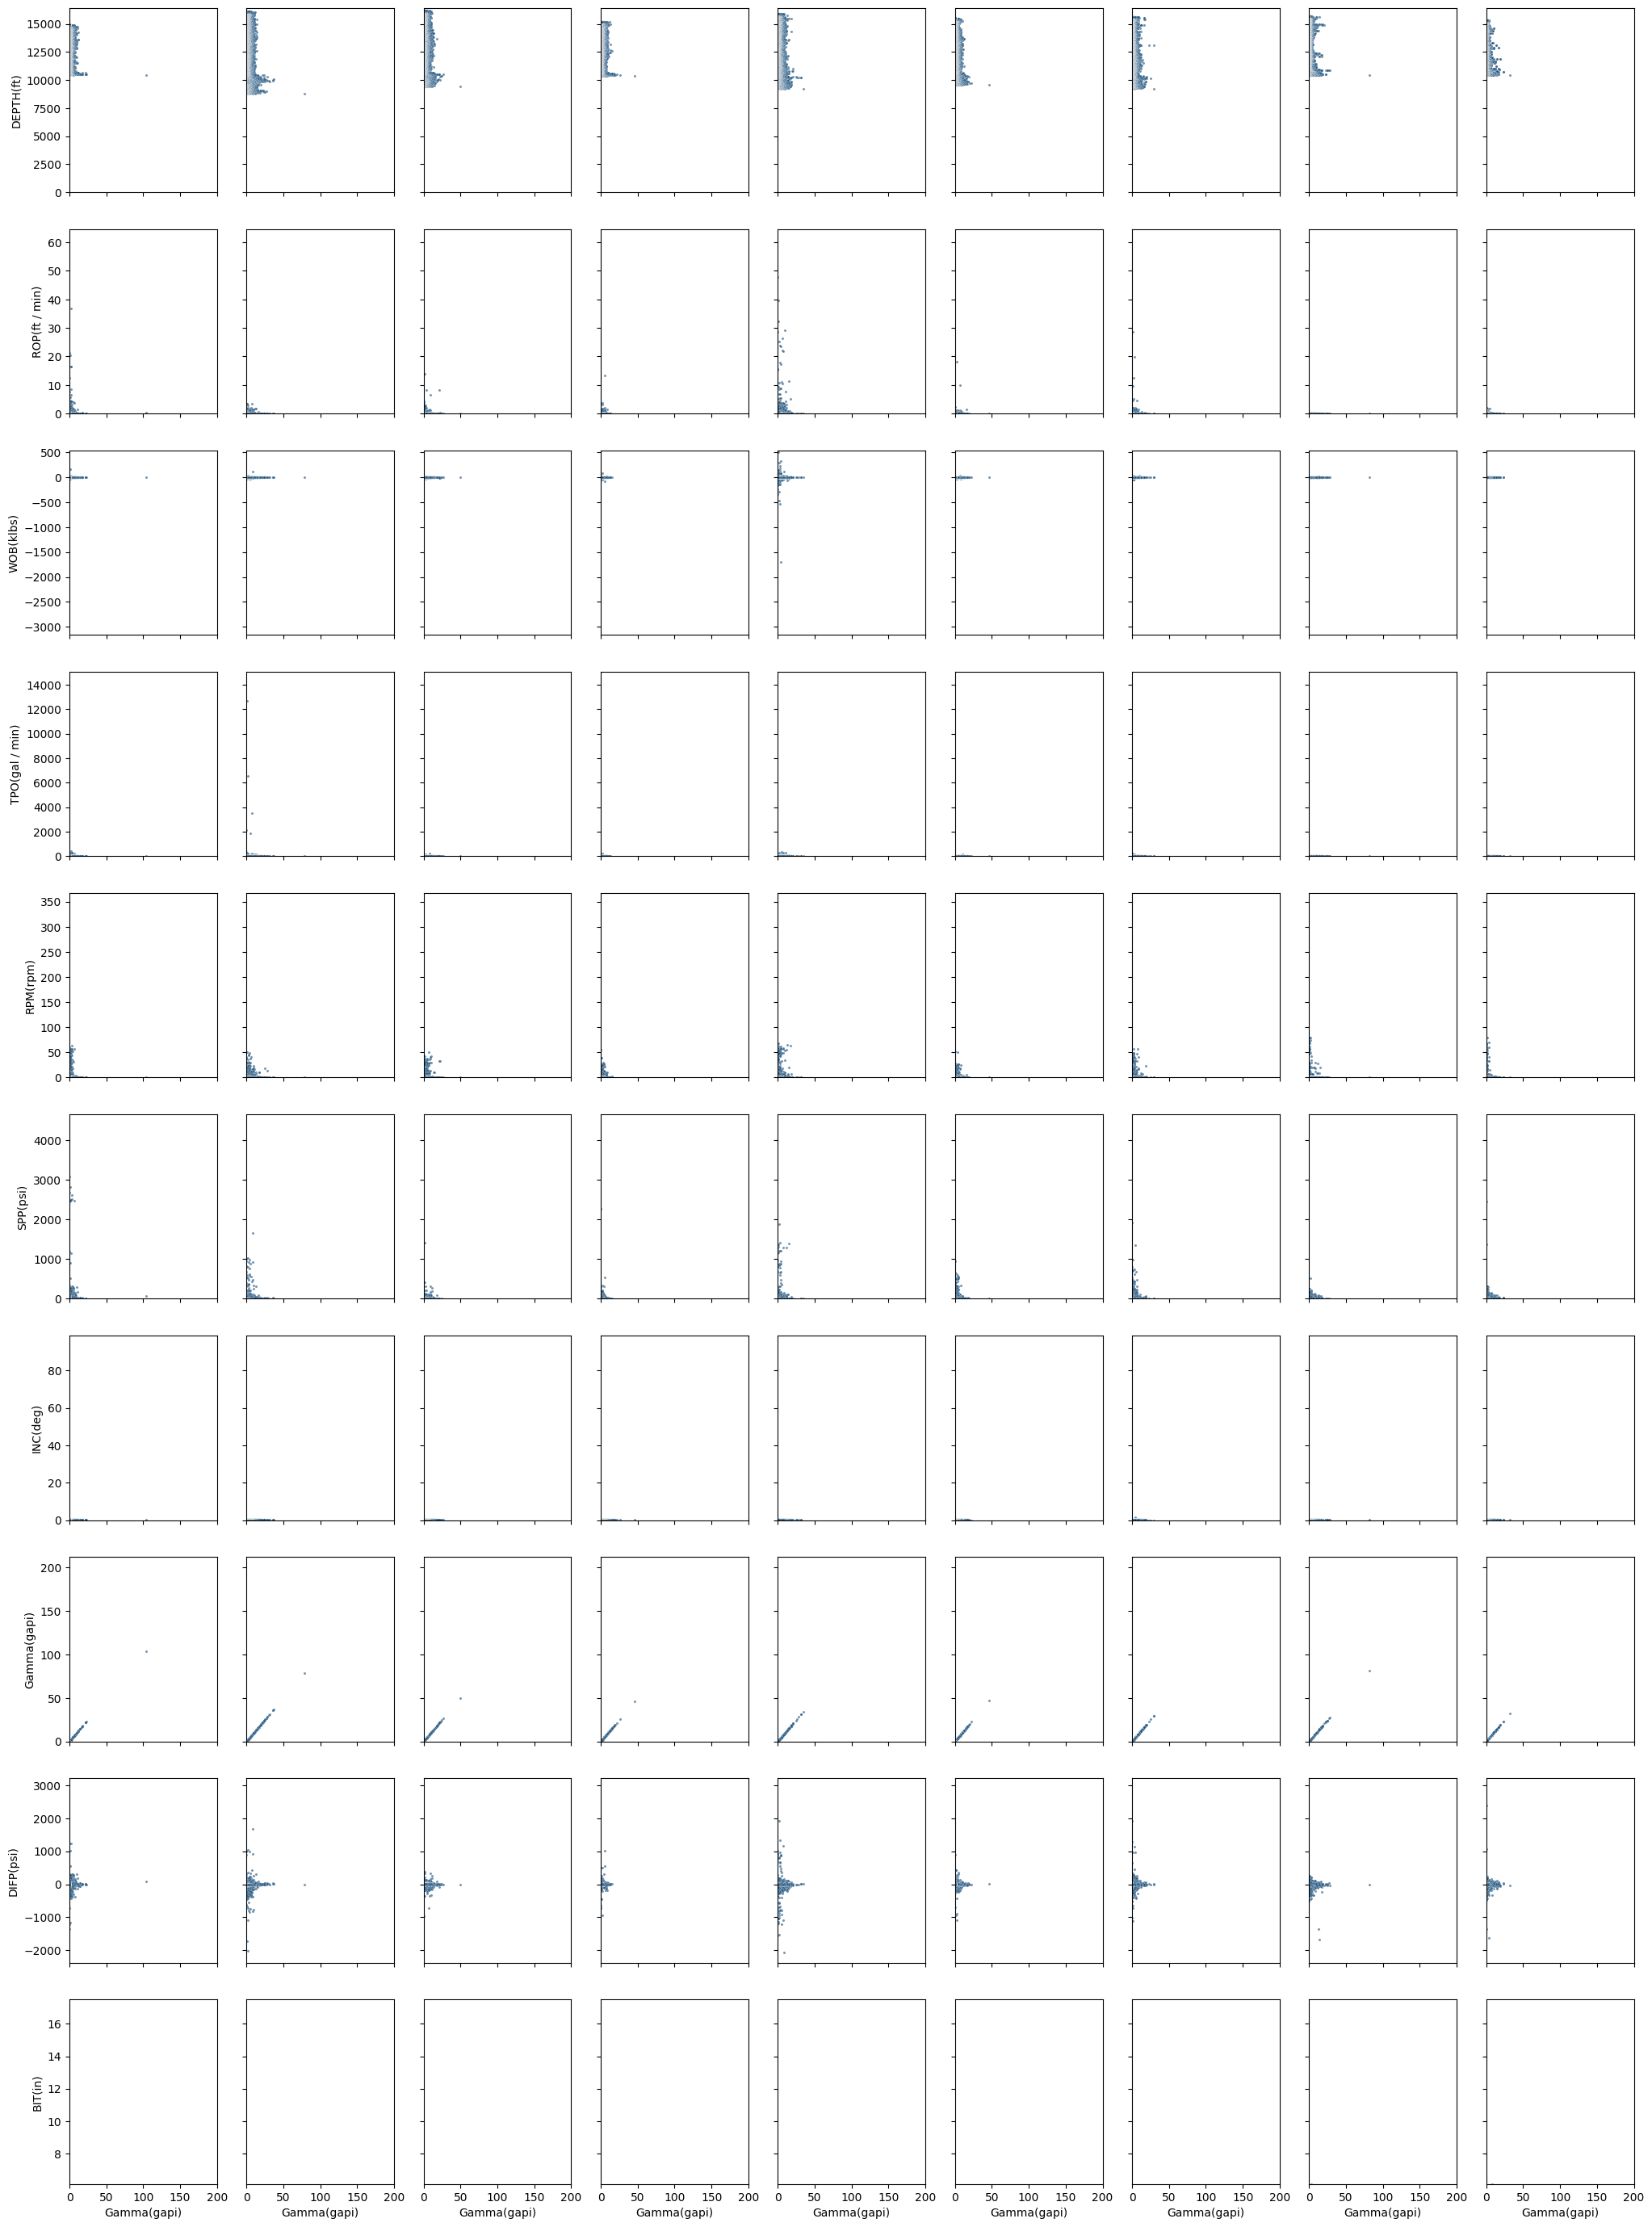

In [246]:
####### look at corr of gamma and other meaasures across datasets - min/max y values based on data.  #######

fig,ax=plt.subplots(len(consistent_col_names),len(file_names),figsize=(25,35))
for j, file_name in enumerate(file_names):
    df=dict_dfs[file_name][consistent_col_names]
    if diff==1:
        df=get_diff(df)
    for i,consistent_col_name in enumerate(consistent_col_names):
        sns.scatterplot(data=df,x='Gamma(gapi)',y=consistent_col_name,alpha=.6,color='#154c79',s=5,ax=ax[i,j])
        if i!=len(consistent_col_names)-1:
            ax[i,j].set_xlabel('')
            ax[i,j].set_xticklabels('')
        if j!=0:
            ax[i,j].set_ylabel('')
            ax[i,j].set_yticklabels('')
        mins= min_value.groupby('measure')['Value'].min()
        maxs= max_value.groupby('measure')['Value'].max()
        ax[i,j].set_ylim(mins[consistent_col_name],maxs[consistent_col_name])
        ax[i,j].set_xlim(0,200)

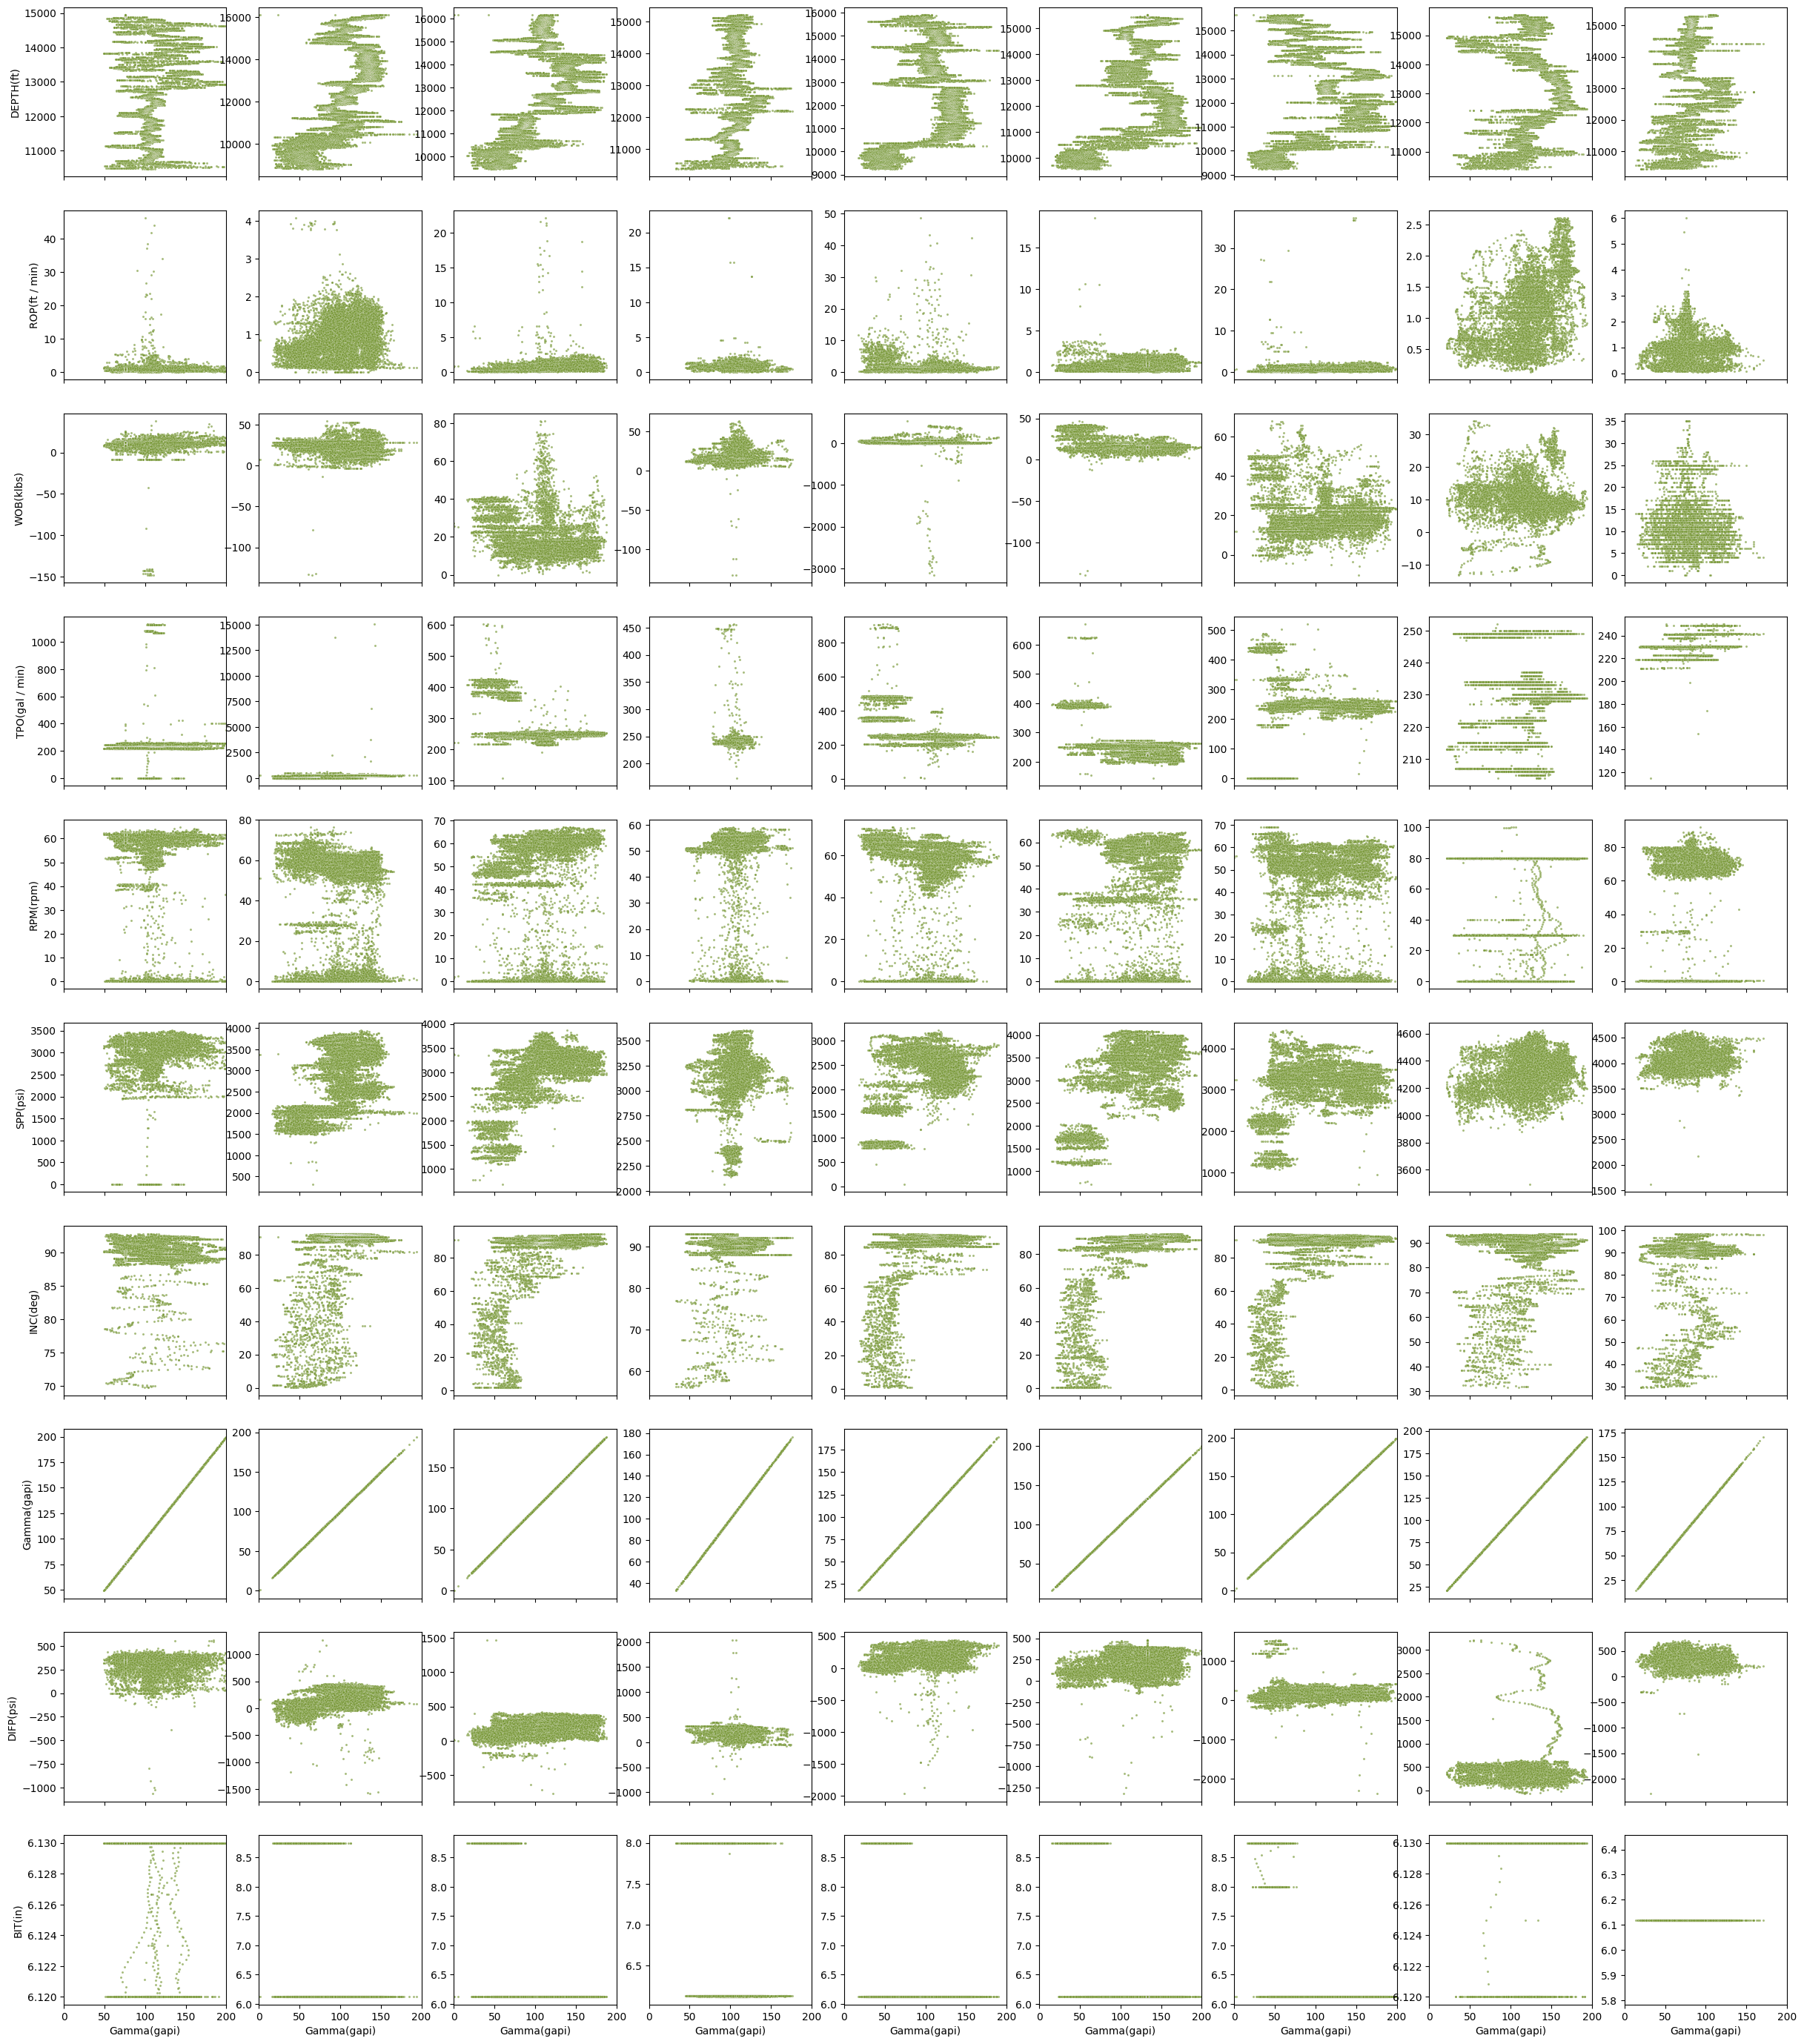

In [15]:
####### look at corr of gamma and other meaasures across datasets - min/max y values based on each graph.  #######

fig,ax=plt.subplots(len(consistent_col_names),len(file_names),figsize=(30,35))
for j, file_name in enumerate(file_names):
    df=dict_dfs[file_name][consistent_col_names]
    if diff==1:
        df=get_diff(df)
    for i,consistent_col_name in enumerate(consistent_col_names):
        sns.scatterplot(data=df,x='Gamma(gapi)',y=consistent_col_name,alpha=.6,color='#154c79',s=5,ax=ax[i,j])
        if i!=len(consistent_col_names)-1:
            ax[i,j].set_xlabel('')
            ax[i,j].set_xticklabels('')
        if j!=0:
            ax[i,j].set_ylabel('')
            # ax[i,j].set_yticklabels('')
        ax[i,j].set_xlim(0,200)
        



In [16]:
# missing percent of measure in each dataset
dfs=pd.DataFrame()
for j, file_name in enumerate(file_names):
    df=dict_dfs[file_name][consistent_col_names]
    dfs= pd.concat([dfs,pd.DataFrame(100*(df[df['Gamma(gapi)'].notna()].isna().sum()/df[df['Gamma(gapi)'].notna()].shape[0]),columns=[j])],axis=1)

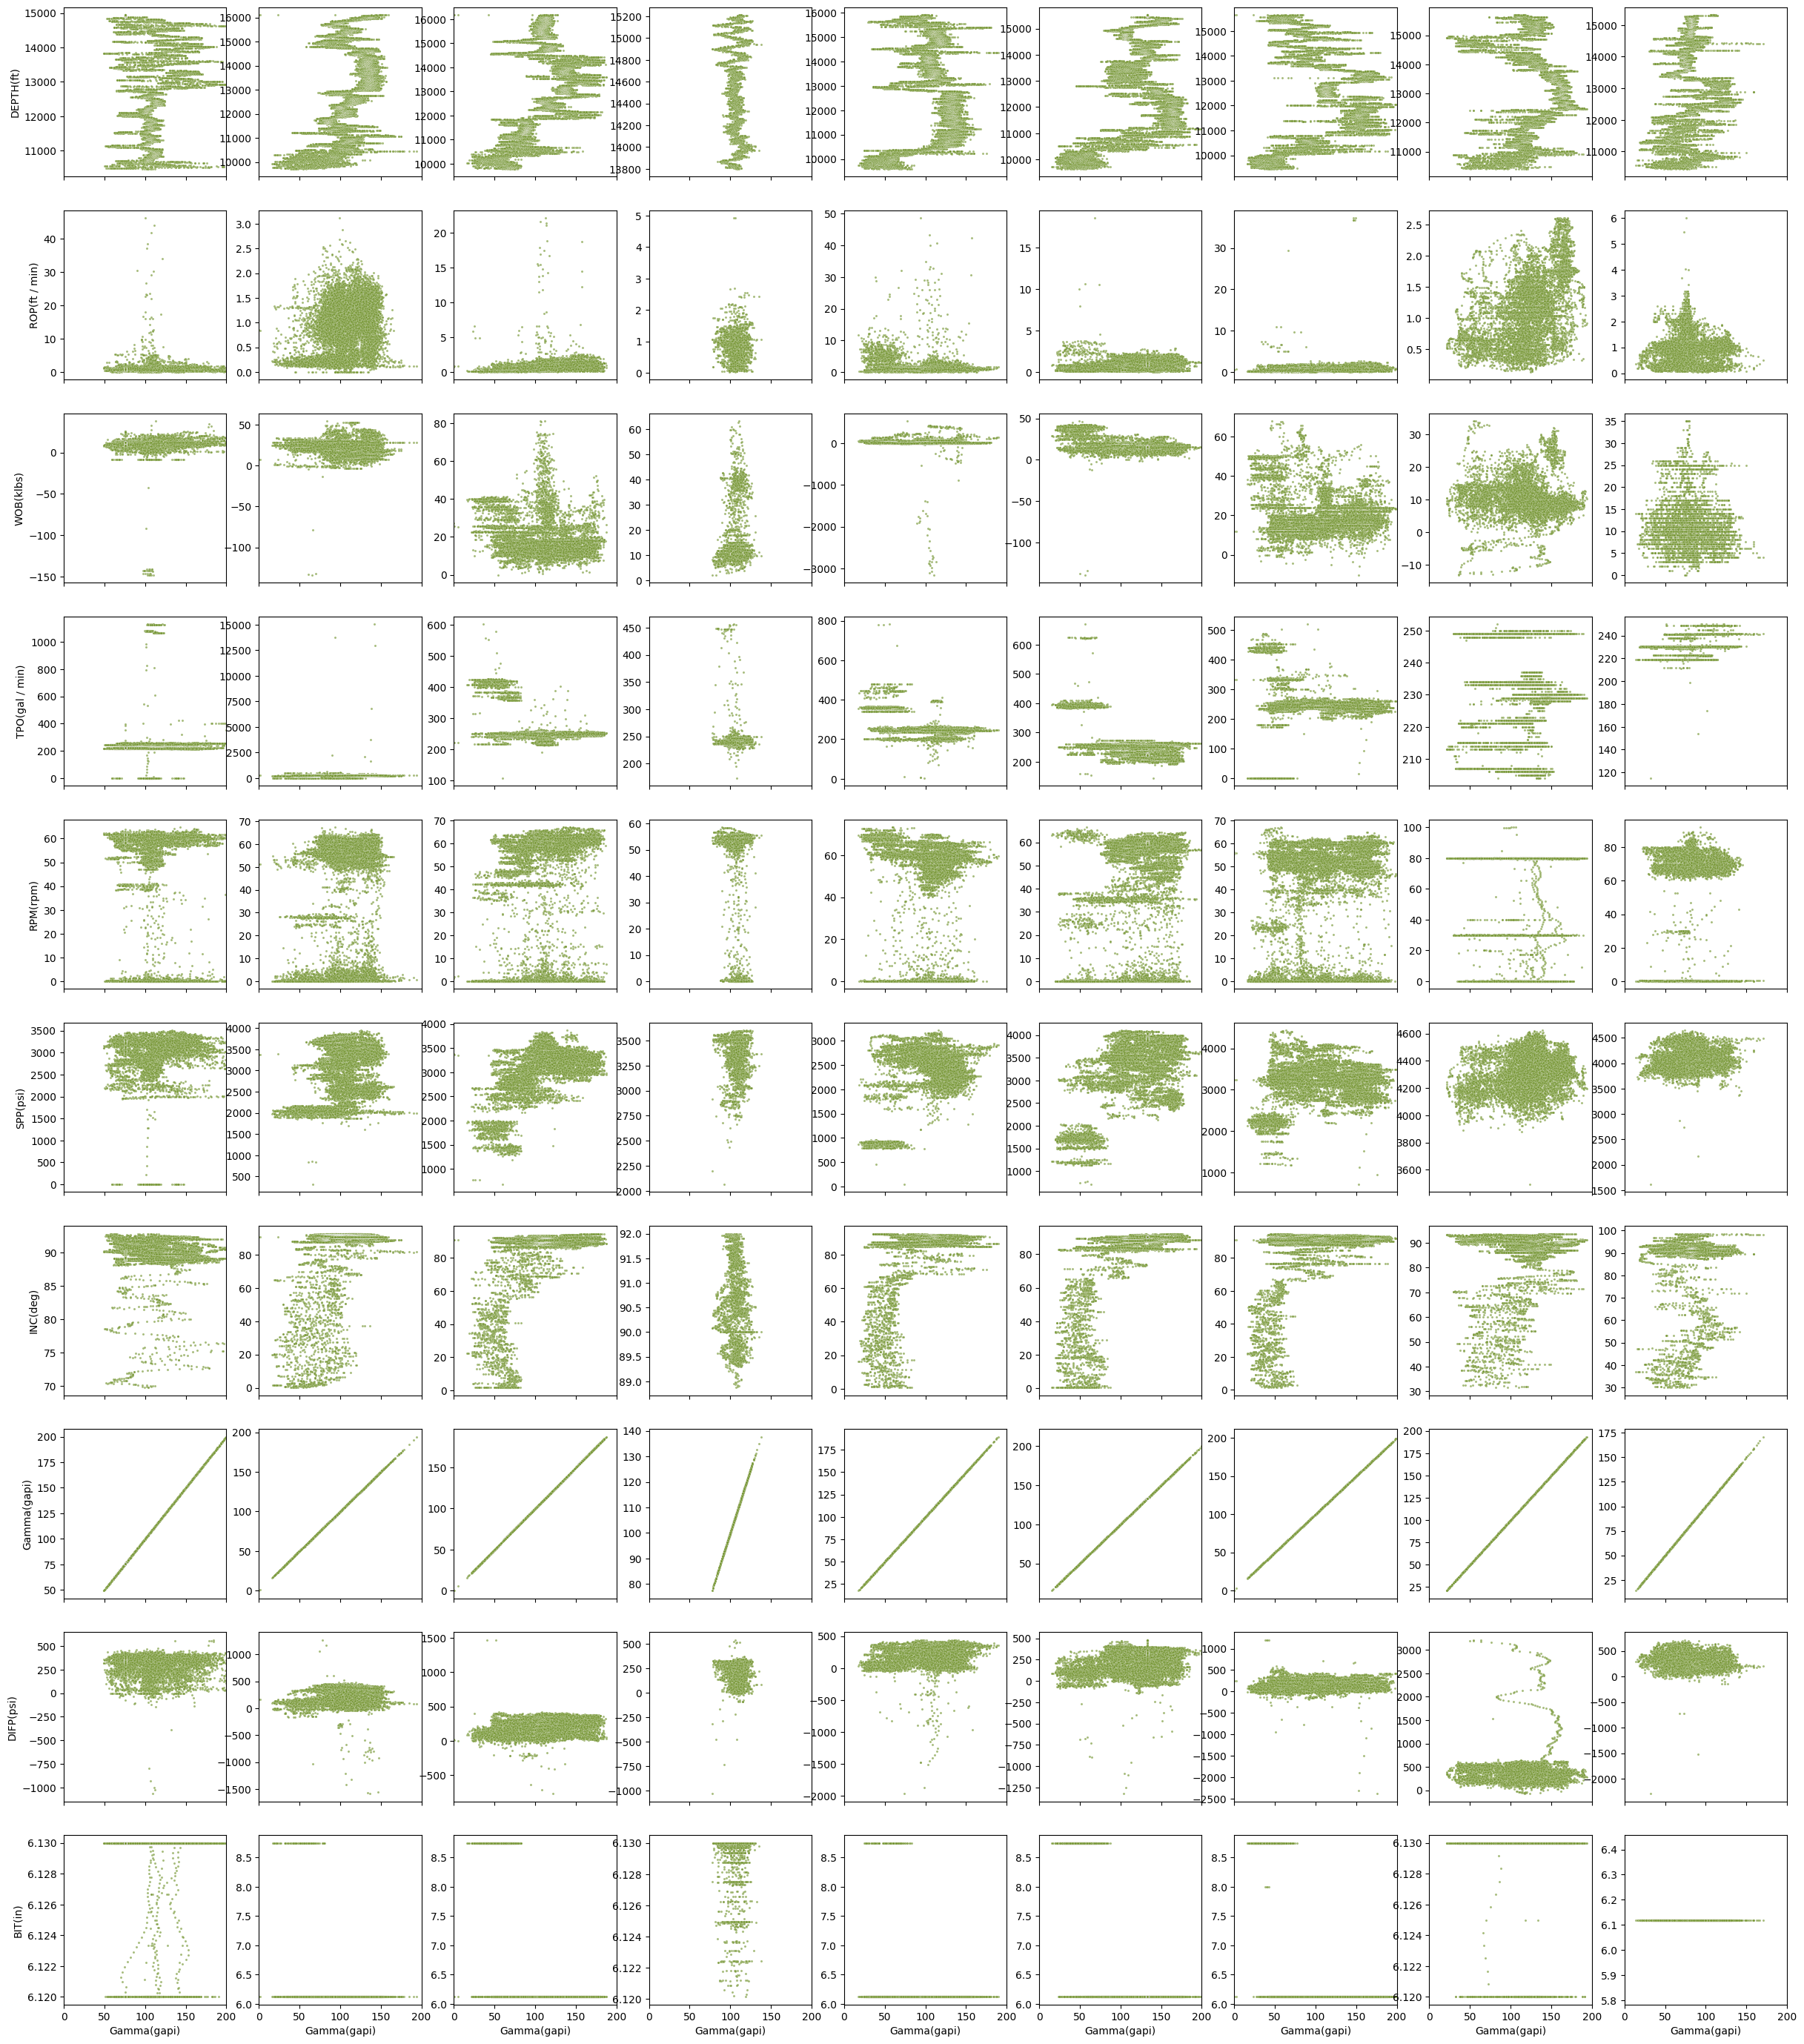

In [17]:
####### look at corr of gamma and other meaasures across datasets - min/max y values based on each graph. No missing data at any depth #######

fig,ax=plt.subplots(len(consistent_col_names),len(file_names),figsize=(30,35))
for j, file_name in enumerate(file_names):
    df=dict_dfs[file_name][consistent_col_names]
    if diff==1:
        df=get_diff(df)
    df=df[df['Gamma(gapi)'].notna()].dropna()
    for i,consistent_col_name in enumerate(consistent_col_names):
        sns.scatterplot(data=df,x='Gamma(gapi)',y=consistent_col_name,alpha=.6,color='#154c79',s=5,ax=ax[i,j])
        if i!=len(consistent_col_names)-1:
            ax[i,j].set_xlabel('')
            ax[i,j].set_xticklabels('')
        if j!=0:
            ax[i,j].set_ylabel('')
            # ax[i,j].set_yticklabels('')
        ax[i,j].set_xlim(0,200)

In [247]:
#### create spike filters ####
def moving_median_despiker(feature):
    start_indx = 0
    end_indx = 50
    i = 0
    mean_thresh=0.25
    ma_filtered = []

    for i in range(0, len(feature)):
        # get the mean of the surrounding end_indx*2 feature
        mean_surround_10feature = np.median(
            np.concatenate([feature[start_indx + i : end_indx + i], feature[start_indx - end_indx + i : start_indx + i]])
        )
        if np.abs(feature[i]) >= np.abs(mean_thresh * mean_surround_10feature):
            ma_filtered.append(mean_surround_10feature)
        else:
            ma_filtered.append(feature[i])
    feature=pd.Series(ma_filtered)
    
    # filter outliers
    outliers = (feature>=(feature.mean() + feature.std()*2)) | (feature<=(feature.mean() - feature.std()*2))
    feature = np.where(outliers,feature.mean(),feature)
    return feature

#### plot_relationships of features with gamma or ROP ####
def plot_relationships(df,diff,consistent_col_names,moving_median_despike=0):
    cols=list(pd.Series(consistent_col_names)[~pd.Series(consistent_col_names).isin(['DEPTH(ft)','Gamma(gapi)',])])

    fig,ax=plt.subplots(1,len(cols),figsize=(20,10),constrained_layout=True)
    for i,col in enumerate(cols):
        
        df1 = df[['Gamma(gapi)',col]].dropna()
        scaler =preprocessing.StandardScaler().fit(np.array(df1))
        X_scaled = scaler.transform(np.array(df1))
        df1 = pd.DataFrame(X_scaled,columns=df1.columns)
        df1['DEPTH(ft)'] =df['DEPTH(ft)']
        
        if moving_median_despike == 1:
            df1[col] = moving_median_despiker(df1[col])
            title='Despiked (2std outliers and moving median: 25 ft, 25%)'
        else:
            title='No despiking'

        if diff==1:
            df1=get_diff(df1)
        sns.lineplot(data=df1,y='DEPTH(ft)',x='Gamma(gapi)',color='#154c79',alpha=.5,label='Gamma(gapi)',orient="y",ax=ax[i])
        sns.lineplot(data=df1,y='DEPTH(ft)',x=col,color='#e28743',alpha=.8,label=col,orient="y",ax=ax[i])
        ax[0].set_ylabel('DEPTH(ft)',fontsize=16,labelpad=10)
        if i !=0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
        ax[i].set_xlabel('')
        corrdf = df1[['Gamma(gapi)',col]].dropna()
        r,p=scipy.stats.pearsonr(corrdf['Gamma(gapi)'], corrdf[col])  
        r = np.round(r,4)
        leg=ax[i].legend(frameon=False,loc='upper center',bbox_to_anchor=(.5,1.18),fontsize=12,)
        leg._legend_box.align = "bottom"

        ax[i].set_ylim(df1['DEPTH(ft)'].min()-100,df1['DEPTH(ft)'].max()+100)
        ax[i].set_title(f"Correlation\nr = {r}",fontsize=14,color='#873e23')

    fig.suptitle(f"Relationships between Gamma and other features - {title}\n{file_names[0].replace('.csv','')}",horizontalalignment='left',fontsize=18,x=0.05,y=.95,)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.close()
    return fig



In [248]:
pdf = PdfPages("despiking_example_gamma.pdf")
figs=[]
for file_name in file_names:
    df=dict_dfs[file_name][consistent_col_names]
    f1=plot_relationships(df,diff,consistent_col_names,0)
    f2 =plot_relationships(df,diff,consistent_col_names,1)
    figs.append(f1)
    figs.append(f2)
    plt.close()
for fig in figs:
    pdf.savefig(fig) # saves the active handle
pdf.close()


## umap


In [24]:
####### remove correlated features above .9 #######
# for j, file_name in enumerate(file_names):
df=dict_dfs[file_names[0]][consistent_col_names]
# df=df[df['Gamma(gapi)'].notna()].dropna()
# corr_df= df.corr()
# corr_df=corr_df.dropna(how='all').dropna(axis=1)
# corr_df=corr_df[corr_df.abs()>.9]

# # remove correlated features above .9
# possibly_remove=[]
# found_corrs=[]
# for c in corr_df.columns:
#     high_corrs=pd.Series(corr_df[c].dropna().index)
#     if len(high_corrs)!=1:
#         if list(high_corrs) not in found_corrs:
#             found_corrs.append(list(high_corrs))
#             possibly_remove.extend(list(high_corrs[~high_corrs.isin([c])]))
# print(possibly_remove,'removed due to being highly correled (r>0.9)')
# new_col_names = list(pd.Series(consistent_col_names)[~pd.Series(consistent_col_names).isin(possibly_remove)])



In [25]:
####### standardize data #######
df=dict_dfs[file_names[0]]
df=df[consistent_col_names].dropna()
df1=df[df.columns[~df.columns.isin(['Gamma(gapi)','DEPTH(ft)','BIT(in)','SPP(psi)'])]]
scaler =preprocessing.StandardScaler().fit(np.array(df1))
X_scaled = scaler.transform(np.array(df1))


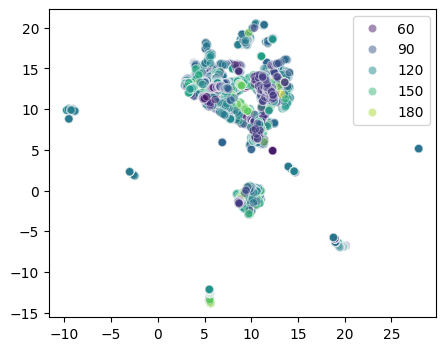

In [26]:
####### UMAP transform #######
reducer = umap.UMAP(min_dist=0.1,n_neighbors=250,output_metric='mahalanobis',)
embedding = reducer.fit_transform(X_scaled)

fig,ax = plt.subplots(figsize=(5,4))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],alpha=.5,hue=df['Gamma(gapi)'],ax=ax,palette='viridis')
ax.legend(bbox_to_anchor=(1,1))
